In [2]:
# Set threading parameters before importing TensorFlow
import os
import multiprocessing

# Set environment variables
os.environ["OMP_NUM_THREADS"] = "20"
os.environ['TF_NUM_INTRAOP_THREADS'] = '20'
os.environ['TF_NUM_INTEROP_THREADS'] = '20'

import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate, Multiply, Permute, Lambda, Reshape, Activation, Dropout, Add, GlobalMaxPooling1D, GlobalAvgPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pydot

# Set threading configuration
tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

In [3]:
print(tf.__version__)
print(tf.config.experimental.list_physical_devices('GPU'))

tf.test.is_built_with_cuda()

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Intra op parallelism threads: ", tf.config.threading.get_intra_op_parallelism_threads())
print("Inter op parallelism threads: ", tf.config.threading.get_inter_op_parallelism_threads())


Num GPUs Available:  1
Intra op parallelism threads:  20
Inter op parallelism threads:  20


### GPU and CPU configuration  

In [5]:
# ensuring Tensorflow is using the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found. Using the CPU instead.")


1 Physical GPUs, 1 Logical GPUs


### Run this section only if there exists string values

In [7]:
# Function to clean the 'Time' column
def clean_time_column(df):
    # Ensure the 'Time' column is treated as a string
    df['Time'] = df['Time'].astype(str)
    # Remove the unit 'sec' from the 'Time' column
    df['Time'] = df['Time'].str.replace(' sec', '', regex=False)
    # Convert the 'Time' column to a numeric type
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    return df

# Function to handle missing values
def handle_missing_values(df, method='drop', fill_value=0):
    if method == 'drop':
        # Drop rows with missing values
        df = df.dropna()
    elif method == 'fill':
        # Fill missing values with a specified value
        df = df.fillna(fill_value)
    elif method == 'interpolate':
        # Interpolate missing values
        df = df.interpolate()
    else:
        raise ValueError("Invalid method for handling missing values. Use 'drop', 'fill', or 'interpolate'.")
    return df

# Function to clean all files in a given list and save them to a directory
def clean_csv_files(files, save_directory, missing_value_method='fill', fill_value=0):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)  # Create directory if it doesn't exist
    
    for file in files:
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Check if 'Time' column exists
        if 'Time' in df.columns:
            # Clean the 'Time' column
            df = clean_time_column(df)
            # Handle missing values
            df = handle_missing_values(df, method=missing_value_method, fill_value=fill_value)
            # Define the new file path with the same name but in the save directory
            filename = os.path.basename(file)
            cleaned_file_path = os.path.join(save_directory, filename)
            # Save the cleaned file
            df.to_csv(cleaned_file_path, index=False)
            print(f"Cleaned file saved: {cleaned_file_path}")
        else:
            print(f"No 'Time' column found in file: {file}")

# Directory where you want to save the cleaned files
save_directory = r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data"

# List all of the CSV file paths
stator_csv_files_str = [r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\01_SCIM_current_allfault_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\02_SCIM_current_PTPab_400V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\03_SCIM_current_PTPab_480V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\04_SCIM_current_PTGa_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\05_SCIM_current_PTGb_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\06_SCIM_current_PTGc_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\07_SCIM_current_PTPbc_400V.csv"]

rotor_csv_files_str = [r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\01_SCIM_vibration_allfault_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\02_SCIM_vibration_PTPab_400V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\03_SCIM_vibration_PTPab_480V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\04_SCIM_vibration_PTGa_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\05_SCIM_vibration_PTGb_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\06_SCIM_vibration_PTGc_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data-with_string\07_SCIM_vibration_PTPbc_400V.csv"]

# Clean the stator and rotor CSV files and save them to the specified directory
print("Cleaning stator files...")
clean_csv_files(stator_csv_files_str, save_directory)
print("\nCleaning rotor files...")
clean_csv_files(rotor_csv_files_str, save_directory)

Cleaning stator files...
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\01_SCIM_current_allfault_360V.csv
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\02_SCIM_current_PTPab_400V.csv
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\03_SCIM_current_PTPab_480V.csv
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\04_SCIM_current_PTGa_360V.csv
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\05_SCIM_current_PTGb_360V.csv
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\06_SCIM_current_PTGc_360V.csv
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\07_SCIM_current_PTPbc_400V.csv

Cleaning rotor files...
Cleaned file saved: D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\01_SCIM_vibration_allfault_360V.csv
Cleaned file saved: D:\MTdataset\

## Load the data from CSV files


In [8]:
# List all of the CSV file paths
stator_csv_files = [r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\01_SCIM_current_allfault_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\02_SCIM_current_PTPab_400V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\03_SCIM_current_PTPab_480V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\04_SCIM_current_PTGa_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\05_SCIM_current_PTGb_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\06_SCIM_current_PTGc_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\07_SCIM_current_PTPbc_400V.csv"]

rotor_csv_files = [r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\01_SCIM_vibration_allfault_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\02_SCIM_vibration_PTPab_400V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\03_SCIM_vibration_PTPab_480V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\04_SCIM_vibration_PTGa_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\05_SCIM_vibration_PTGb_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\06_SCIM_vibration_PTGc_360V.csv",
r"D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data\07_SCIM_vibration_PTPbc_400V.csv"]

# Read the CSV files into pandas dataframe and convert to numpy arrays
stator_data = [pd.read_csv(file).values for file in stator_csv_files]
rotor_data = [pd.read_csv(file).values for file in rotor_csv_files]

# Split the data into taining and validation set
train_size = int(len(stator_data[0]) * 0.8) # 80% training data and 20% validation data

train_stator_data = [data[:train_size] for data in stator_data]
val_stator_data = [data[train_size:] for data in stator_data]

train_rotor_data = [data[:train_size] for data in rotor_data]
val_rotor_data = [data[train_size:] for data in rotor_data]

### Data Normalization

In [9]:
# Compute mean and std for normalization
def compute_mean_std(data):
    concatenated_data = np.concatenate(data, axis= 0)
    mean = np.mean(concatenated_data, axis= 0)
    std = np.std(concatenated_data, axis= 0)
    return mean, std

# Normalize the data
def normalize_data(data, mean, std):
    return [(d - mean) / std for d in data]

# Compute mean and std for stator and rotor data
stator_mean, stator_std = compute_mean_std(train_stator_data)
rotor_mean, rotor_std = compute_mean_std(train_rotor_data) 

# Normalize the training data 
stator_train_data_normalized = normalize_data(train_stator_data, stator_mean, stator_std)
rotor_train_data_normalized = normalize_data(train_rotor_data, rotor_mean, rotor_std)

# Normalize the validation data using the training data statistics
stator_val_data_normalized = normalize_data(val_stator_data, stator_mean, stator_std)
rotor_val_data_normalized = normalize_data(val_rotor_data, rotor_mean, rotor_std)

### Data generator function

In [10]:
def data_generator(stator_data, rotor_data, sequence_length=100, batch_size=32):
    # get the number of samples
    num_samples = stator_data[0].shape[0] - sequence_length     

    # Infinite loop to continuously yield the batches
    while True:
        # Generate batches
        for start_idx in range(0, num_samples, batch_size):
            stator_batch = []
            rotor_batch = []
            batch_y = []

            for i in range(batch_size):
                end_idx = start_idx + i + sequence_length
                if end_idx >= num_samples:
                    break
                # Create sequences of length 'Sequence length'
                stator_seq = [data[start_idx + i:end_idx, 1:] for data in stator_data] # excluding the time column
                rotor_seq = [data[start_idx + i:end_idx, 1] for data in rotor_data] # excluding the time column & vibration is the only remaining column
            
                # Target is the next time step's 'Time' value in stator data (same as rotor data)
                y = stator_data[0][end_idx, 0] # assuming time is the first column in the stator files

                stator_batch.append(np.concatenate(stator_seq, axis=-1))
                rotor_batch.append(np.concatenate(rotor_seq, axis=-1))
                batch_y.append(y)
        if len(stator_batch) == batch_size:
            X_stator = np.array(stator_batch)
            X_rotor = np.array(rotor_batch)
            y = np.array(batch_y)

            #concatenating data along the last axis
            yield [X_stator, X_rotor], y 

In [11]:
# Create the data generator for both training and validation data with the normalized data

train_generator = data_generator(stator_train_data_normalized, rotor_train_data_normalized, sequence_length=100, batch_size=32)
validation_generator = data_generator(stator_val_data_normalized, rotor_val_data_normalized, sequence_length=100, batch_size=32)

## Create the BiLSTM network with Time and Channel attention

### Defining Time attention and Channel attention mechanisms

In [12]:
# Define the time attention mechanism 
class TimeAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(TimeAttentionLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W_omega = Dense(hidden_size, use_bias=False)
        self.b_omega = Dense(hidden_size, use_bias=False)
        self.u_omega = self.add_weight(shape=(hidden_size,), initializer='random_normal', trainable=True, name='u_omega')

    def call(self, inputs):
        u_t = tf.nn.tanh(self.W_omega(inputs) + self.b_omega(inputs))
        alpha_t = tf.nn.softmax(tf.reduce_sum(u_t * self.u_omega, axis=2, keepdims=True), axis=1)
        context_vector = tf.reduce_sum(alpha_t * inputs, axis=1)
        return context_vector

class ChannelAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.input_shape_param = input_shape
        self.gmp = GlobalMaxPooling1D()
        self.gap = GlobalAvgPool1D()
        self.fcl = Dense(input_shape, activation='linear')
        self.m = Dense(input_shape // 8, activation='relu')
        self.v = Dense(input_shape // 8, activation='relu')
        self.n = Dense(input_shape // 8, activation='relu')
        self.W11 = Dense(input_shape // 8, activation='relu')
        self.W12 = Dense(input_shape, activation='linear')
        self.W21 = Dense(input_shape // 8, activation='relu')
        self.W22 = Dense(input_shape, activation='linear')

    def build(self, input_shape):
        super(ChannelAttentionLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        batch_size, sequence_length, feature_dim = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2]

        # GMP and GAP for descriptors m and v
        gmp = self.gmp(inputs)
        gap = self.gap(inputs)
        
        # Fully Connected Layer for descriptor n
        fcl = self.fcl(inputs)

        # Descriptors
        m = self.m(gmp)
        v = self.v(gap)
        n = self.n(fcl)

        # Multilayer Perceptrons
        W11 = self.W11(v)
        W12 = self.W12(W11)

        W21 = self.W21(m)
        W22 = self.W22(W21)

        # reshape the descriptors to match before adding (newly updated on 11.07.2024 after errors)
        W12_reshaped = tf.reshape(W12, [-1, feature_dim])
        W22_reshaped = tf.reshape(W22, [-1, feature_dim])
        n_reshaped = tf.reshape(n, [-1, feature_dim])

        # Combine using element-wise summation and add n
        combined = Add()([W12_reshaped, W22_reshaped, n_reshaped])

        # Activation function to get attention weights
        attention_weights = Activation('hard_sigmoid')(combined)

        # Tile attention weights to match the input shape (newly updated on 11.07.2024 after errors)
        attention_weights = tf.reshape(attention_weights, [batch_size, 1, feature_dim])
        attention_weights = tf.tile(attention_weights, [1, sequence_length, 1])

        # Apply attention weights
        channel_attention = Multiply()([inputs, attention_weights])
        return channel_attention

## Define the model with Keras-tuner Hyperparameter tuning

In [ ]:
# input shape for stator and rotor data
stator_input_shape = (100, 6) # (sequence_length, number of stator features)
rotor_input_shape = (100, 1) # (sequence_length, number of rotor features)

# Define the model with modified channel attention mechanism and dropout
def build_model(hp):
    hidden_size = hp.Int('hidden_size', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    dense_size = hp.Int('dense_size', min_value=32, max_value=128, step=32)

    # Stator current input
    input_stator = Input(shape=stator_input_shape, name='stator_input')
    lstm_stator = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_stator)
    time_attention_stator = TimeAttentionLayer(hidden_size)(lstm_stator)

    # Rotor vibration input
    input_rotor = Input(shape=rotor_input_shape, name='rotor_input')    
    lstm_rotor = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_rotor)
    time_attention_rotor = TimeAttentionLayer(hidden_size)(lstm_rotor)

    # Concatenate and Dense layers with Dropout
    concatenated = Concatenate()([time_attention_stator, time_attention_rotor])
    concatenated = tf.expand_dims(concatenated, axis=1)
    channel_attention_layer = ChannelAttentionLayer(hidden_size * 2)(concatenated)
    dense1 = Dense(dense_size, activation='relu')(tf.squeeze(channel_attention_layer, axis=1))
    dropout1 = Dropout(dropout_rate)(dense1)
    output = Dense(1)(dropout1)

    model = Model(inputs=[input_stator, input_rotor], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Setup the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='mca_bilstm_tuning'
)

# Display the search space summary
tuner.search_space_summary()

tuner.search(train_generator, steps_per_epoch=(len(train_stator_data[0]) - 100) // 32, epochs=10, 
             validation_data=validation_generator, validation_steps=(len(val_stator_data[0]) - 100) // 32, 
             use_multiprocessing=True)

# function to check if the graphviz package is working properly
def check_graphviz():
    try:
        # Attempt to create an image of a blank graph to check the pydot/graphviz installation.
        pydot.Dot.create(pydot.Dot())
        return True
    except (OSError, Exception) as e:
        if isinstance(e, OSError):
            print("Graphviz not found.")
        else:
            print("Some other exception occurred with pydot.")
        return False

### Build and Train the Best model obtained

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hidden size: {best_hps.get('hidden_size')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best dense rate: {best_hps.get('dense_size')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
# best_model.fit(train_generator, steps_per_epoch=(len(train_stator_data[0]) - 100) // 32, epochs=10,
               # validation_data=validation_generator, validation_steps=(len(val_stator_data[0]) - 100 // 32)

In [ ]:

# Check if Graphviz is installed correctly
# if check_graphviz():
    # Save the model architecture to a file
    # plot_model(model, to_file='bilstm_model.png', show_shapes=True)
# else:
    # print("Graphviz is not installed or not in PATH.")

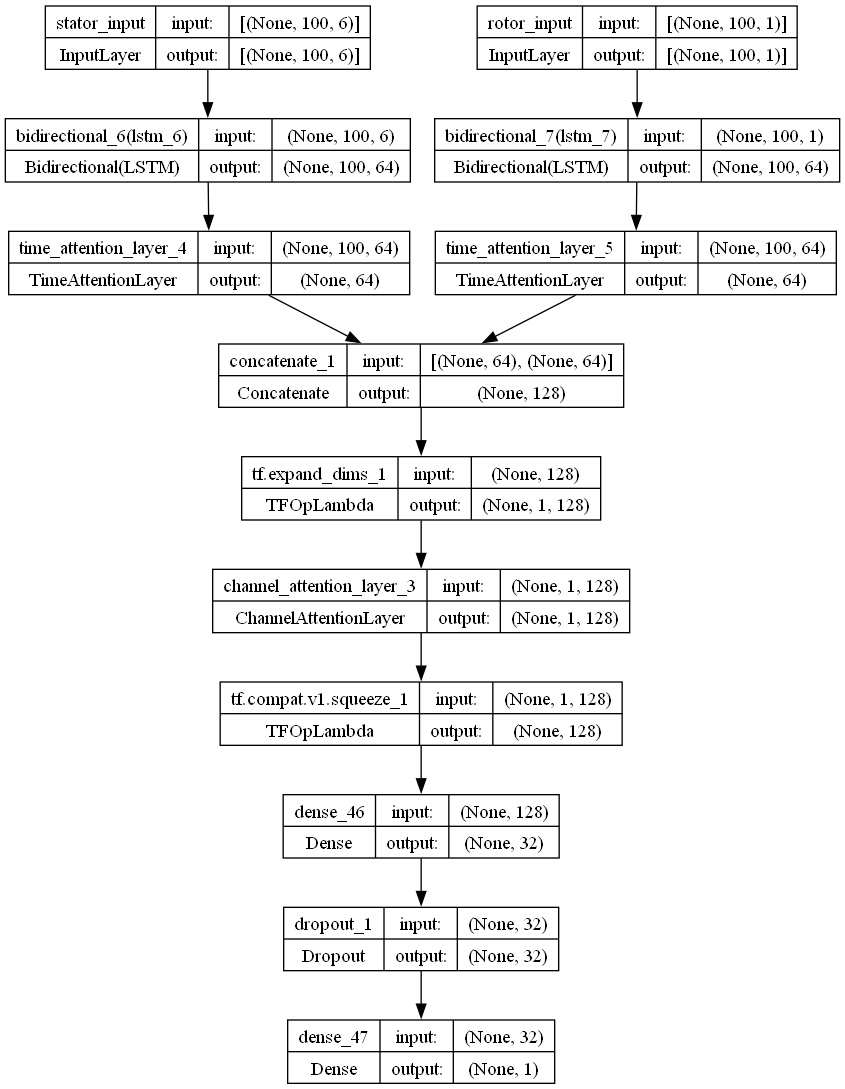

In [18]:
# Visualization Functions
def visualize_bilstm(input_shape):
    input_layer = Input(shape=input_shape)
    bilstm_layer = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    model = Model(inputs=input_layer, outputs=bilstm_layer)
    return model

def visualize_time_attention(input_shape, hidden_size):
    input_layer = Input(shape=input_shape)
    attention_output = TimeAttentionLayer(hidden_size)(input_layer)
    model = Model(inputs=input_layer, outputs=attention_output)
    return model

def visualize_channel_attention(input_shape, hidden_size):
    input_layer = Input(shape=input_shape)
    attention_output = ChannelAttentionLayer(hidden_size)(input_layer)
    model = Model(inputs=input_layer, outputs=attention_output)
    return model


bilstm_model = visualize_bilstm((100, 6))  # Adjust input_shape accordingly
plot_model(bilstm_model, to_file='bilstm_model.png', show_shapes=True)

time_attention_model = visualize_time_attention((100, 128), hidden_size=128)  # Adjust input_shape accordingly
plot_model(time_attention_model, to_file='time_attention_model.png', show_shapes=True)

channel_attention_model = visualize_channel_attention((100, 128), hidden_size=128)  # Adjust input_shape accordingly
plot_model(channel_attention_model, to_file='channel_attention_model.png', show_shapes=True)

# Build the full model for visualization
hp = kt.HyperParameters()
model = build_model(hp)
# Visualize the entire model
plot_model(model, to_file='full_model.png', show_shapes=True)

### Calculation of Model accuracy using MSE, RMSE, MAE and R2

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming `predictions` and `true_y` are already defined as per the previous code
mse = mean_squared_error(true_y, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_y, predictions)
r2 = r2_score(true_y, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')